## Demo of filter


This notebook demonstrates the use of the Kalman filter.

Contents:

1. Canonical Example

2. Likelihood curves

## Setup 


First lets quickly set up some bits

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import sys
# Hacky way to add higher directory to python modules path. 
# Means that I dont have to make src/ a proper python package
try:
    sys.path.remove("../src") 
except:
    pass
sys.path.append("../src") 

## 1. Canonical example 

This is effectively the same steps that are taken by `main.py`


In [25]:
from system_parameters import SystemParameters
from pulsars import Pulsars
from synthetic_data import SyntheticData
from model import LinearModel
from kalman_filter import KalmanFilter
from priors import bilby_priors_dict

import numpy as np 



#Setup and create some synthetic data
P    = SystemParameters(h=1e-10,σp=1e-15,σm=1e-12,Npsr=20,cadence=0.5)    # System parameters read from config file
PTA  = Pulsars(P)                       # All pulsar-related quantities
data = SyntheticData(PTA,P)             # Given the system parameters and the PTA configuration, create some synthetic data

#Define the model to be used by the Kalman Filter
model = LinearModel(P,PTA)

#Initialise the Kalman filter
KF = KalmanFilter(model,data.f_measured,PTA=PTA)

#Run the KF with the correct parameters.
#We get the correct parameters via Bilby dictionary, looking towards when we will run this with nested sampling
init_parameters,optimal_parameters_dict = bilby_priors_dict(PTA,P,set_state_parameters_as_known=True,set_measurement_parameters_as_known=True)
optimal_parameters                      = optimal_parameters_dict.sample(1)    
x_results,y_results,model_likelihood                        = KF.run(optimal_parameters)




INFO:root:Welcome to the Slow Kalman Filter
INFO:root:Random seed is 1234
INFO:root:Setting the bilby priors dict
INFO:root:Setting fully informative priors on GW parameters
INFO:root:Setting fully informative priors on PSR parameters


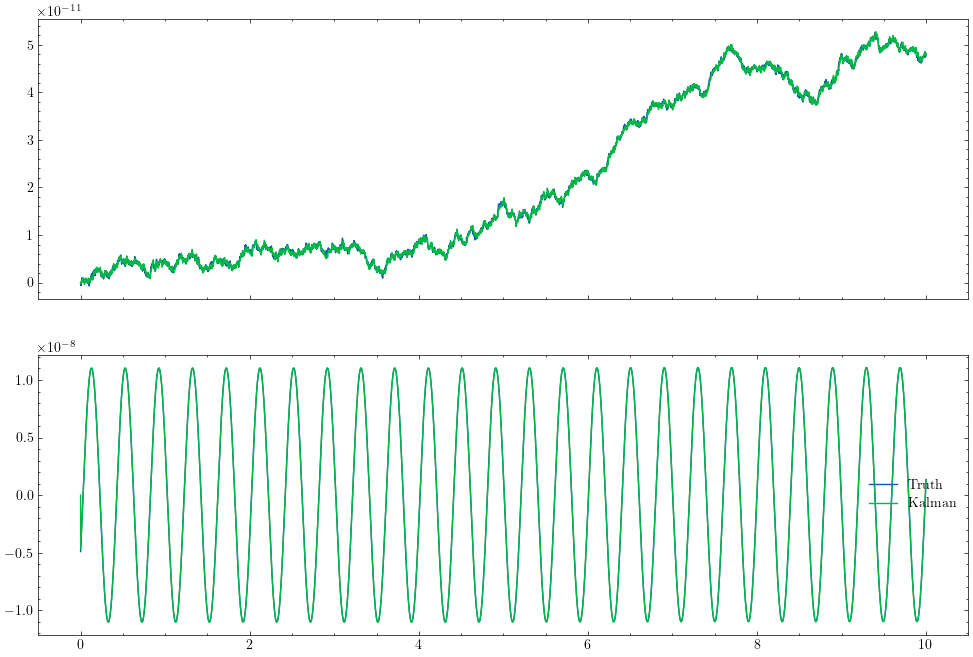

In [26]:
from plotting import plot_synthetic_data



plot_synthetic_data(data.t,data.state,data.f_measured,x_results,y_results,state_index=0,observation_index=0)

## 2. Likelihood curves 


Essential to using a Kalman filter in conjunction with a Bayesian-inference technique like nested sampling is the ability to generate accurate likelihoods. Lets look at what the likelihood curves look like.

In [56]:

from tqdm import tqdm 
#Get a snapshot of the likelihood for these parameters
def likelihood_curve(data,P,PTA,model,parameter_name,parameter_value):

    #re-Initialise the Kalman filter
    KF = KalmanFilter(model,data.f_measured,PTA=PTA)

    #Run the KF, with a different parameter value
    init_parameters,optimal_parameters_dict = bilby_priors_dict(PTA,P,set_state_parameters_as_known=True,set_measurement_parameters_as_known=True)
    optimal_parameters                      = optimal_parameters_dict.sample(1)    
    optimal_parameters[parameter_name]      = parameter_value
    x_results,y_results,model_likelihood    = KF.run(optimal_parameters)


    return model_likelihood



#Iterate over parameters
def generate_likelihood_curve(parameter_name,parameter_values,data,P,PTA,model):
    likelihoods = np.zeros_like(parameter_values)
    for i,pv in tqdm(enumerate(parameter_values)):
        likelihoods[i] = likelihood_curve(data,P,PTA,model,parameter_name,pv)

    return likelihoods




In [57]:
#Setup and create some synthetic data
P    = SystemParameters(h=1e-10)    # System parameters read from config file
PTA  = Pulsars(P)                       # All pulsar-related quantities
data = SyntheticData(PTA,P)             # Given the system parameters and the PTA configuration, create some synthetic data

#Define the model to be used by the Kalman Filter
model = LinearModel(P,PTA)



INFO:root:Welcome to the Slow Kalman Filter
INFO:root:Random seed is 1234


### 2.1 Likelihood curve for $\Omega$

In [58]:
parameter_name='omega_gw'
Nvals = 100
parameter_values = np.logspace(-7,-6,Nvals)
omega_likelihoods = generate_likelihood_curve(parameter_name,parameter_values,data,P,PTA,model)


100it [01:18,  1.27it/s]


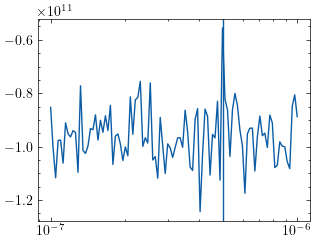

In [59]:
import matplotlib.pyplot as plt 
plt.plot(parameter_values,omega_likelihoods)
plt.xscale('log')
plt.axvline(5e-7)

### 2.2 Likelihood curve for $\Phi_0$

In [62]:
parameter_name='phi0_gw'
Nvals = 100
parameter_values = np.linspace(0.0,2*np.pi,Nvals)
phi0_likelihoods = generate_likelihood_curve(parameter_name,parameter_values,data,P,PTA,model)


0it [00:00, ?it/s]

100it [01:22,  1.21it/s]


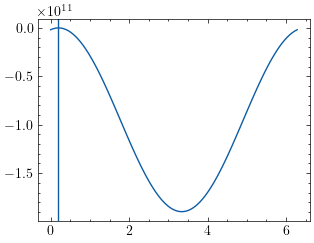

In [63]:
plt.plot(parameter_values,phi0_likelihoods)
plt.axvline(P.Φ0)

### 2.3 Likelihood curve for $\psi$

In [64]:
parameter_name='psi_gw'
Nvals = 100
parameter_values = np.linspace(0.0,2*np.pi,Nvals)
psi_likelihoods = generate_likelihood_curve(parameter_name,parameter_values,data,P,PTA,model)


100it [01:08,  1.45it/s]


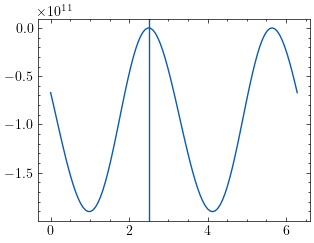

In [65]:
plt.plot(parameter_values,psi_likelihoods)
plt.axvline(P.ψ)

### 2.4 Likelihood curve for $\iota$

In [66]:
parameter_name='iota_gw'
Nvals = 100
parameter_values = np.linspace(0.0,np.pi,Nvals)
iota_likelihoods = generate_likelihood_curve(parameter_name,parameter_values,data,P,PTA,model)


100it [01:11,  1.39it/s]


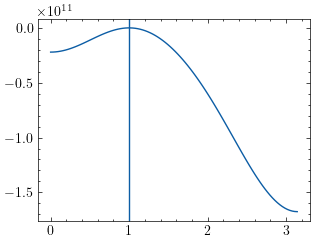

In [67]:
plt.plot(parameter_values,iota_likelihoods)
plt.axvline(P.ι)

### 2.5 Likelihood curve for $\delta$

In [68]:
parameter_name='delta_gw'
Nvals = 100
parameter_values = np.linspace(-np.pi,np.pi,Nvals)
delta_likelihoods = generate_likelihood_curve(parameter_name,parameter_values,data,P,PTA,model)


100it [01:17,  1.28it/s]


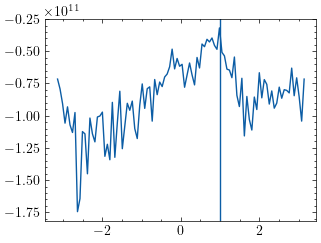

In [69]:
plt.plot(parameter_values,delta_likelihoods)
plt.axvline(P.δ)

### 2.6 Likelihood curve for $\alpha$

In [70]:
parameter_name='alpha_gw'
Nvals = 100
parameter_values = np.linspace(0,2*np.pi,Nvals)
alpha_likelihoods = generate_likelihood_curve(parameter_name,parameter_values,data,P,PTA,model)


100it [01:17,  1.29it/s]


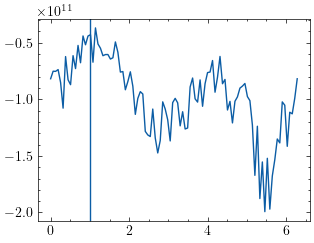

In [71]:
plt.plot(parameter_values,alpha_likelihoods)
plt.axvline(P.α)

### 2.7 Likelihood curve for $h$

In [72]:
parameter_name='h'
Nvals = 100
parameter_values = np.logspace(-11,-9,Nvals)
h_likelihoods = generate_likelihood_curve(parameter_name,parameter_values,data,P,PTA,model)


100it [01:08,  1.45it/s]


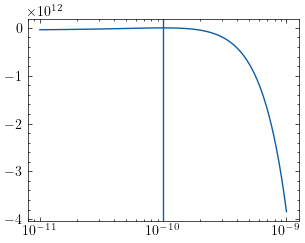

In [73]:
plt.plot(parameter_values,h_likelihoods)
plt.axvline(P.h)
plt.xscale('log')